In [1]:
# data/plot management
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

# plotting/mapmaknig
import geopandas as gpd
import contextily as cx
import shapely
import cartopy.crs as ccrs

# import folium

# webscraping
import json
import urllib
from bs4 import BeautifulSoup
from urllib.request import urlopen

# os
import subprocess
import os
import glob
import regionmask 

In [2]:
main_path = "C:\\Users\david\\Documents\\nc_file_storage"

In [3]:
# combine all data sets, rakes long to run so only run if needed
run = False 
if run:
    files = []
    for year in [1998, 1999, 2000,2001,2018,2019,2020,2021]:
        for month in [1,2,3,4,5,6,7,8,9,10,11,12]:
            rel_path = f'{month}-{year}'
            file_location = os.path.join(main_path, rel_path)
            files.append(glob.glob(f'{file_location}\*.nc'))
    files = sum(files, [])
    ds = xr.open_mfdataset(files)
    ds.to_netcdf(os.path.join(main_path,"combined_ds.nc"))

In [28]:
ds = xr.open_mfdataset(os.path.join(main_path,"combined_ds_1998-2021.nc")).load()

In [5]:
ds

<xarray.Dataset>
Dimensions:      (time: 3648, nv: 2, lat: 480, lon: 1440)
Coordinates:
  * time         (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2021-12-31
  * lat          (lat) float32 -59.88 -59.62 -59.38 -59.12 ... 59.38 59.62 59.88
  * lon          (lon) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Dimensions without coordinates: nv
Data variables:
    time_bounds  (time, nv) datetime64[ns] dask.array<chunksize=(3648, 2), meta=np.ndarray>
    lat_bounds   (time, lat, nv) float32 dask.array<chunksize=(3648, 480, 2), meta=np.ndarray>
    lon_bounds   (time, lon, nv) float32 dask.array<chunksize=(3648, 1440, 2), meta=np.ndarray>
    cmorph       (time, lat, lon) float32 dask.array<chunksize=(3648, 480, 1440), meta=np.ndarray>
Attributes: (12/57)
    ncei_template_version:      NCEI_NetCDF_Grid_template_V2.0
    title:                      NOAA Climate Data Record (CDR) of CPC Morphin...
    keywords:                   Precipitation, Satellite, High-Resolution, Gl...
    summary:                    The CMORPH CDR is a reprocessed and bias-corr...
    references:                 Xie, P., et al. (2017), Reprocessed, Bias-Cor...
    Conventions:                CF-1.6, ACDD-1.3
    ...                         ...
    geospatial_lat_resolution:  0.25
    geospatial_lat_units:       degrees_north
    geospatial_lon_min:         0.0
    geospatial_lon_max:         360.0
    geospatial_lon_resolution:  0.25
    geospatial_lon_units:       degrees_east

<GeoAxes: >

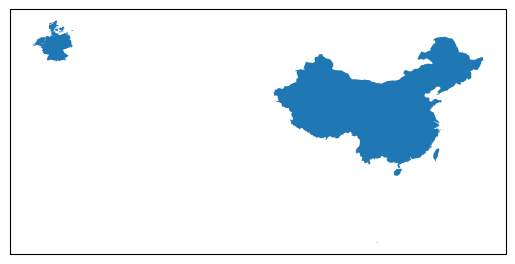

In [6]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))

gdf = gpd.read_file("Countries.geojson")
gdf.plot(ax=ax)

In [7]:
gdf

,scalerank,labelrank,sovereignt,sov_a3,adm0_dif,level,type,admin,adm0_a3,geou_dif,...,region_un,subregion,region_wb,name_len,long_len,abbrev_len,tiny,homepart,featureclass,geometry
0,1.0,2.0,China,CH1,1.0,2.0,Country,China,CHN,0.0,...,Asia,Eastern Asia,East Asia & Pacific,5.0,5.0,5.0,-99.0,1.0,Admin-0 country,"MULTIPOLYGON (((110.88877 19.99194, 110.93828 ..."
1,1.0,3.0,Taiwan,TWN,0.0,2.0,Sovereign country,Taiwan,TWN,0.0,...,Asia,Eastern Asia,East Asia & Pacific,6.0,6.0,6.0,-99.0,1.0,Admin-0 country,"MULTIPOLYGON (((118.40742 24.52212, 118.45117 ..."
2,3.0,6.0,Singapore,SGP,0.0,2.0,Sovereign country,Singapore,SGP,0.0,...,Asia,South-Eastern Asia,East Asia & Pacific,9.0,9.0,5.0,3.0,1.0,Admin-0 country,"POLYGON ((103.96973 1.33145, 103.81992 1.26538..."
3,1.0,4.0,Denmark,DN1,1.0,2.0,Country,Denmark,DNK,0.0,...,Europe,Northern Europe,Europe & Central Asia,7.0,7.0,4.0,-99.0,1.0,Admin-0 country,"MULTIPOLYGON (((11.36143 54.89165, 11.53838 54..."
4,1.0,2.0,Germany,DEU,0.0,2.0,Sovereign country,Germany,DEU,0.0,...,Europe,Western Europe,Europe & Central Asia,7.0,7.0,4.0,-99.0,1.0,Admin-0 country,"MULTIPOLYGON (((14.19824 53.91904, 14.21367 53..."
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Netherlands,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"MULTIPOLYGON (((4.22617 51.38647, 4.21143 51.3..."


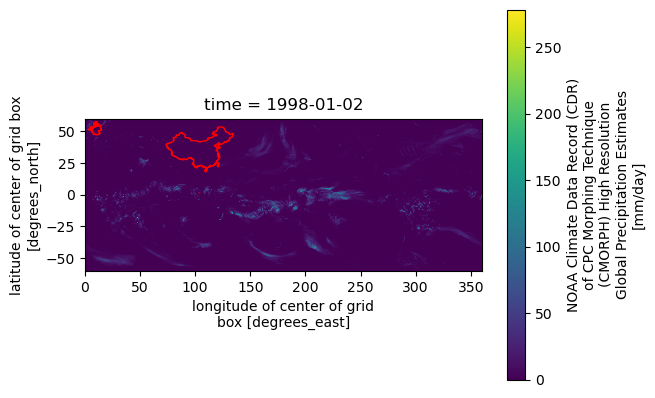

In [8]:
# f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax = gdf.plot(zorder=1,edgecolor="r", facecolor="None")
ds.cmorph.isel(time=1).plot(ax=ax, zorder=-1)

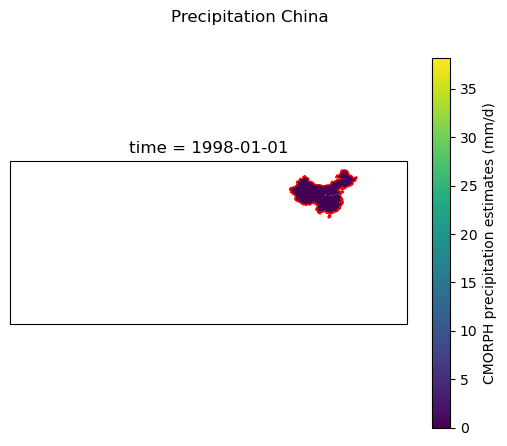

In [9]:
country_index = 0
country_gdf = gdf.iloc[country_index]

mask = regionmask.mask_geopandas(gdf, #.iloc[[country_index]], 
                                 ds['cmorph'].lon.to_numpy(), 
                                 ds['cmorph'].lat.to_numpy(),
                                 lon_name="lon",
                                 lat_name="lat")
cropped_ds = ds.where(mask==0)
# mean_ds = cropped_ds.mean(dim=["lat","lon"])
# df_ts = pd.DataFrame(mean_ds.cmorph.to_pandas(),columns=["cmorph"])


f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
contour_plot = cropped_ds.isel(time=0).cmorph.plot(ax=ax)
contour_plot.colorbar.set_label("CMORPH precipitation estimates (mm/d)")
gdf.iloc[[country_index]].plot(zorder=1,edgecolor="r", facecolor="None",ax=ax)

xmin, ymin, xmax, ymax = country_gdf.geometry.bounds
# ax.set_xlim((xmin, xmax))
# ax.set_ylim((ymin, ymax))
f.suptitle(f"Precipitation {country_gdf.admin}");

Steden

1- Beijing / Shanghai / Guangzhou / Chongqing / Wuhan.

2- Amsterdam / Maastricht

3- Copenhagen

4- Singapore

5- Taipei /Khaohsiung

6- Berlin / Munich / Keulen

In [10]:
d = {'city': ['Beijing', 'Shanghai','Guangzhou', 'Chongqing', 'Wuhan', 'Amsterdam', 'Maastricht', 'Copenhagen', 'Singapore',
              'Taipei', 'Kaohsiung City','Berlin','Munich','Keulen'], 
     'country': ['China']*5 + ['Netherlands']*2 + ['Denmark', 'Singapore'] +['Taiwan']*2 + ['Germany']*3}

In [11]:
gdf_cities = gpd.GeoDataFrame(data=d)
gdf_cities['combined_name'] = gdf_cities.apply(lambda x: x.city + ',' + x.country,axis=1)
loc_gdf = gpd.tools.geocode(gdf_cities.combined_name)

In [12]:
df = pd.concat([gdf_cities,loc_gdf],axis=1)
gdf_cities = gpd.GeoDataFrame(data=df, geometry=df.geometry)

In [13]:
gdf_cities

,city,country,combined_name,geometry,address
0,Beijing,China,"Beijing,China",POINT (116.41214 40.19063),"北京市, 中国"
1,Shanghai,China,"Shanghai,China",POINT (121.47002 31.23127),"上海市, 中国"
2,Guangzhou,China,"Guangzhou,China",POINT (113.25929 23.13020),"广州市, 广东省, 中国"
3,Chongqing,China,"Chongqing,China",POINT (106.54792 29.56567),"重庆市, 400014, 渝中区, 重庆, 中国"
4,Wuhan,China,"Wuhan,China",POINT (114.29994 30.59511),"武汉市, 湖北省, 中国"
5,Amsterdam,Netherlands,"Amsterdam,Netherlands",POINT (4.89245 52.37308),"Amsterdam, Noord-Holland, Nederland"
6,Maastricht,Netherlands,"Maastricht,Netherlands",POINT (5.69098 50.85124),"Maastricht, Limburg, Nederland"
7,Copenhagen,Denmark,"Copenhagen,Denmark",POINT (12.57007 55.68672),"København, 1357, Region Hovedstaden, Danmark"
8,Singapore,Singapore,"Singapore,Singapore",POINT (103.81950 1.35711),"Singapore, Singapore"
9,Taipei,Taiwan,"Taipei,Taiwan",POINT (121.46566 25.01200),"新北市, 臺灣"


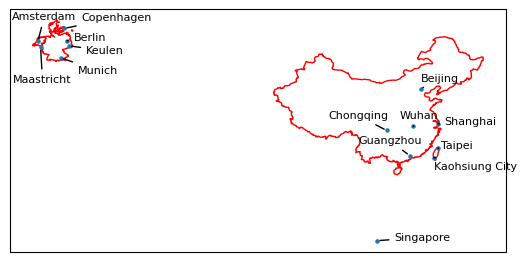

In [14]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
gdf.plot(facecolor="None",edgecolor="r",ax=ax)
gdf_cities.plot(ax=ax,markersize=5)
offset = [[0,2],[2,0],[-15,3],[-17,3],[-4,2],[-7.5,5.5],[-8, -9],[5,2],[5,0],[1,0],[0,-3],[2,0],[5,-4],[5,-2]]
for index, city in enumerate(gdf_cities.city):
    point = gdf_cities.iloc[index].geometry
    ax.annotate(city,
                (point.x,point.y),
                fontsize=8, xytext=(point.x+offset[index][0],
                                    point.y+offset[index][1]),
                arrowprops=dict(facecolor='black',arrowstyle="-",linewidth=1))
# cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery)

In [68]:
lst_cities_df = []
for city_index, city in enumerate(gdf_cities.city):
    city_gdf = gdf_cities.iloc[city_index]
    centre= city_gdf.geometry
    lon_centre,lat_centre = centre.x, centre.y
    lst_cities_df.append(pd.DataFrame(data=ds.sel(lon=lon_centre, lat=lat_centre, method="nearest").cmorph.to_pandas(),columns=[city]))  

In [16]:
df_P_per_city = pd.concat(lst_cities_df,axis=1)
df_P_per_city

,Beijing,Shanghai,Guangzhou,Chongqing,Wuhan,Amsterdam,Maastricht,Copenhagen,Singapore,Taipei,Kaohsiung City,Berlin,Munich,Keulen
time,,,,,,,,,,,,,,
1998-01-01,0.1,0.0,0.0,0.0,0.0,0.8,1.0,0.000000,0.2,0.0,0.0,6.2,0.000000,0.0
1998-01-02,0.0,0.0,0.0,0.0,0.0,7.6,3.3,0.200000,0.0,0.2,0.0,0.0,0.000000,0.0
1998-01-03,0.0,4.4,0.0,0.0,0.0,28.5,1.6,16.200001,22.5,0.1,0.0,0.1,0.300000,0.0
1998-01-04,0.0,0.0,0.0,0.0,0.0,5.9,0.2,0.000000,0.0,1.4,0.0,0.0,0.000000,0.0
1998-01-05,0.0,0.0,0.0,0.0,0.0,4.4,0.0,0.000000,5.1,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.000000,3.0,5.9,0.9,0.0,0.200000,0.0
2021-12-28,0.0,0.0,0.0,0.0,0.0,2.6,12.1,0.100000,0.0,0.1,0.0,0.0,40.799999,0.0
2021-12-29,0.0,0.0,0.0,0.0,0.0,2.5,4.6,0.600000,0.0,0.3,0.1,1.1,16.200001,0.0


# Total precipitation

In [17]:
df_P_yearly_sum = df_P_per_city.resample('Y').sum()
df_P_yearly_split = df_P_yearly_sum.drop(index=df_P_yearly_sum.loc["2003":"2016"].index)

In [18]:
df_P_yearly_split

,Beijing,Shanghai,Guangzhou,Chongqing,Wuhan,Amsterdam,Maastricht,Copenhagen,Singapore,Taipei,Kaohsiung City,Berlin,Munich,Keulen
time,,,,,,,,,,,,,,
1998-12-31,491.700012,1456.700073,1661.900024,1400.700073,1355.099976,1195.500000,589.299988,827.200012,1838.200073,3170.000000,1774.800049,334.700012,631.700012,483.100006
1999-12-31,302.100006,1336.099976,1214.900024,877.900024,1335.500000,1029.400024,417.400024,881.900024,1371.500000,1204.800049,1706.700073,263.200012,529.500000,342.700012
2000-12-31,452.899994,1407.599976,1698.000000,815.600037,958.600037,957.299988,617.500000,946.200012,1185.900024,2138.900146,1376.400024,249.500000,764.600037,360.399994
2001-12-31,336.500000,1340.400024,2106.300049,605.299988,746.400024,1016.900024,656.300049,965.100037,1850.300049,2158.500000,1831.100098,294.000000,431.300018,436.899994
2002-12-31,308.000000,1341.800049,1324.500000,1221.599976,1449.700073,1062.599976,629.400024,1075.700073,1176.599976,1310.500000,662.700012,432.400024,859.000000,482.900024
2017-12-31,568.000000,1548.599976,1509.300049,1077.400024,1182.800049,811.600037,470.399994,484.500000,1838.700073,1889.000000,1272.900024,704.799988,687.200012,576.200012
2018-12-31,506.700012,1531.700073,1574.300049,1308.000000,1168.800049,706.299988,514.900024,340.700012,1652.800049,1583.400024,2531.000000,250.300003,610.100037,310.700012
2019-12-31,472.500031,1652.599976,1804.300049,1419.500000,1073.800049,805.000000,551.700012,443.100006,1432.300049,2085.699951,2193.399902,389.100006,751.600037,427.500000
2020-12-31,552.900024,1735.400024,1654.900024,1247.500000,2189.199951,1028.599976,442.399994,555.200012,1649.200073,1637.099976,1591.000000,375.100006,839.100037,492.100006


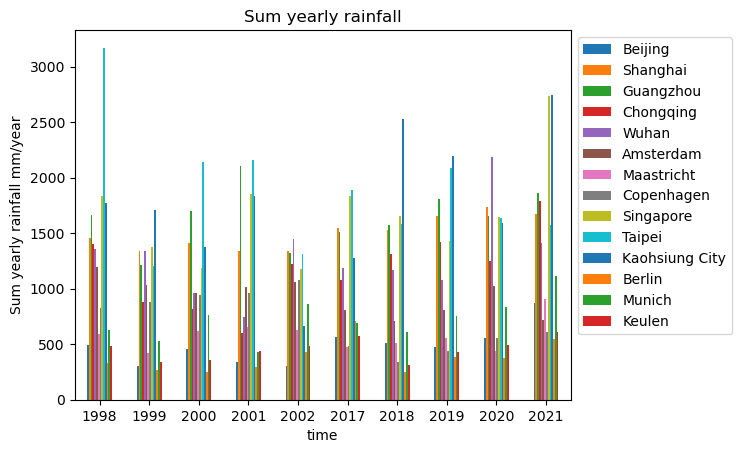

In [19]:
ax = df_P_yearly_split.plot(kind='bar')
ax.legend(bbox_to_anchor=(1,1))
ax.set_xticklabels([i.get_text()[:4] for i in ax.get_xticklabels()],rotation=0);
ax.set_title("Sum yearly rainfall")
ax.set_ylabel("Sum yearly rainfall mm/year");

In [20]:
mean_p_1998_2000 = pd.DataFrame(data=df_P_yearly_sum.loc["1998":"2002"].mean(axis=0),columns=["Mean_P_1998-2002"])
mean_p_2018_2020 =  pd.DataFrame(data=df_P_yearly_sum.loc["2017":"2021"].mean(axis=0),columns=["Mean_P_2017-2021"])
mean_p_per_city = pd.concat([mean_p_1998_2000, mean_p_2018_2020],axis=1)
mean_p_per_city

,Mean_P_1998-2002,Mean_P_2017-2021
Beijing,378.240021,593.940063
Shanghai,1376.519897,1628.519897
Guangzhou,1601.119873,1680.680054
Chongqing,984.220032,1368.119995
Wuhan,1169.060059,1404.840088
Amsterdam,1052.340088,813.400024
Maastricht,581.979980,577.400024
Copenhagen,939.220032,487.139984
Singapore,1484.500122,1861.400024
Taipei,1996.540039,1753.219971


Text(0.5, 1.0, 'Comparison of mean precipitation between 1998-2002 and 2017-2021')

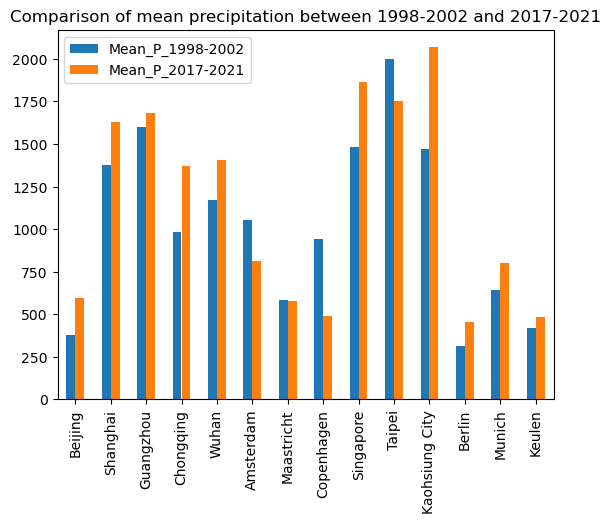

In [21]:
mean_p_per_city.plot(kind='bar')
plt.title("Comparison of mean precipitation between 1998-2002 and 2017-2021")

In [22]:
df_lst_drydays = []
for col in df_P_per_city.columns:
    df_P_rolling = df_P_per_city.copy()
    # How often is it dry for more than one day
    df_dry_days = df_P_rolling[df_P_rolling[col] <= 1].copy()
    count = 0
    for i in range(len(df_dry_days)-1):
        dt = df_dry_days.index[i+1]-df_dry_days.index[i]
        if str(dt)[:6] == '1 days':
            count += 1
        else:
            if count > 0:
                df_dry_days.loc[df_dry_days.index[i], f"{col}_dry_days"] = count + 1
            count = 0
    consecutive_days_dry = df_dry_days.dropna()
    # plt.plot(consecutive_days_dry.index,consecutive_days_dry[f'{col}_dry_days'].values,marker='+',lw=0)
    # plt.title("Amount of consecutive days with no rainfall (<1mm)")
    data = [[col, consecutive_days_dry.loc["1998":"2000",f'{col}_dry_days'].mean(axis=0), len(consecutive_days_dry.loc["1998":"2002",f'{col}_dry_days'])/3,
            consecutive_days_dry.loc["2018":"2020",f'{col}_dry_days'].mean(axis=0), len(consecutive_days_dry.loc["2017":"2021",f'{col}_dry_days'])/3]]

    df = pd.DataFrame(data=data, columns=["city","mean_length_drydays_1998_2002",'N_drydays_1998_2002',"mean_length_drydays_2017_2021","N_drydays_2017_2021"])
    df_lst_drydays.append(df)
    
dry_days_per_city = pd.concat(df_lst_drydays)
dry_days_per_city.reset_index(drop=True,inplace=True)

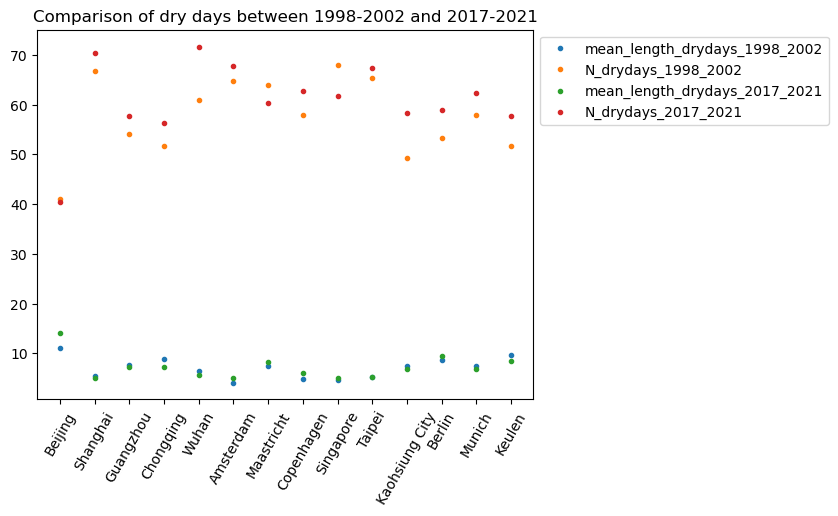

In [23]:
ax = dry_days_per_city.plot(marker=".",lw=0)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xticks(dry_days_per_city.index, dry_days_per_city.city,rotation=60)
plt.title("Comparison of dry days between 1998-2002 and 2017-2021");

In [24]:
df_out = pd.concat([mean_p_per_city, dry_days_per_city.set_index('city',drop=True)],axis=1)
df_out.to_excel("analysis results.xlsx")

# Temperature

https://www.ncei.noaa.gov/products/land-based-station/noaa-global-temp

In [27]:
ds = xr.open_mfdataset(os.path.join(main_path,"NOAAGlobalTemp_v5.1.0_gridded_s185001_e202304_c20230508T152428.nc")).load()

In [26]:
ds

<xarray.Dataset>
Dimensions:  (time: 2080, lat: 36, lon: 72, z: 1)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-04-01
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * z        (z) float32 0.0
Data variables:
    anom     (time, z, lat, lon) float32 dask.array<chunksize=(2080, 1, 36, 72), meta=np.ndarray>
Attributes: (12/66)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           NOAA Merged Land Ocean Global Surface Te...
    summary:                         NOAAGlobalTemp is a merged land-ocean su...
    institution:                     DOC/NOAA/NESDIS/National Centers for Env...
    id:                               gov.noaa.ncdc:C00934 
    naming_authority:                 gov.noaa.ncei 
    ...                              ...
    time_coverage_duration:          P173Y4M
    references:                      Vose, R. S., et al., 2012: NOAAs merged ...
    climatology:                     Climatology is based on 1971-2000 monthl...
    acknowledgment:                  The NOAA Global Surface Temperature Data...
    date_modified:                   2023-05-08T19:24:29Z
    date_issued:                     2023-05-08T19:24:29Z